##Quantum Classifier

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset


import sys          # Standard library module for system-specific parameters and functions
import subprocess   # Standard library module for spawning new processes
from sklearn.preprocessing import MinMaxScaler # Importuje MinMaxScaler do skalowania danych
from sklearn.model_selection import train_test_split # Importuje train_test_split do podziału danych
from ucimlrepo import fetch_ucirepo     # Importuje fetch_ucirepo do pobierania zestawów danych z UCI ML Repository
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score


In [3]:
def ensure_package(pkg_name, import_name=None):
    import_name = import_name or pkg_name
    try:
        __import__(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg_name])

# Ensure all requirements are met
ensure_package('numpy')
ensure_package('scikit-learn', 'sklearn')
ensure_package('ucimlrepo')
ensure_package('qiskit')

def prepare_data():
    """
    Fetches the banknote authentication dataset and returns scaled train/test splits.
    Features are scaled to [0, pi] specifically for Angle Encoding.
    """
    banknote_authentication = fetch_ucirepo(id=267)
    X = banknote_authentication.data.features.to_numpy()
    y = banknote_authentication.data.targets.to_numpy().ravel()

    variance = X[:, 0].reshape(-1, 1)
    skewness = X[:, 1].reshape(-1, 1)

    interaction = skewness * variance
    X_expanded = np.hstack((X, interaction))

    X_train, X_test, y_train, y_test = train_test_split(X_expanded, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test


# Global availability of data
X_tr, X_te, y_tr, y_te = prepare_data()

In [4]:
def ansatz(n_qubits, depth):
    """
    The code below constructs the ansatz. It is built using the Qiskit library
    and utilizes its built-in tools, such as ParameterVector, to easily iterate
    over rotation gate parameters.

    The implementation assumes an even number of layers (depth). Each layer consists
    of a sub-layer of independent gates and a sub-layer of entanglement.
    """

    # Create a vector of learnable parameters.
    # Total parameters = 2 * num_qubits * depth (2 * n_qubits per full loop iteration).
    theta = ParameterVector('θ', 2 * n_qubits * depth)
    qc = QuantumCircuit(n_qubits)

    param_idx = 0

    # The loop iterates (depth // 2) times.
    for j in range(depth // 2):

        # -------- Layer 1 --------

        # Sub-layer: Independent RY rotations
        for i in range(n_qubits):
            qc.ry(theta[param_idx], i)
            param_idx += 1

        # Sub-layer: Entanglement (CRX) - Ring Topology
        # Connects i -> i+1 (wrapping around to 0 at the end)
        for i in range(n_qubits):
            control = i
            target = (i + 1) % n_qubits
            qc.crx(theta[param_idx], control, target)
            param_idx += 1


        # -------- Layer 2 --------

        # Sub-layer: Independent RX rotations
        for i in range(n_qubits):
            qc.rx(theta[param_idx], i)
            param_idx += 1

        # Sub-layer: Entanglement (CRY) - Reverse Ring Topology
        # Connects i -> i-1 (wrapping around to N-1)
        for i in range(n_qubits):
            control = i
            target = (i - 1) % n_qubits
            qc.cry(theta[param_idx], control, target)
            param_idx += 1

    return qc

In [5]:
"""
    The code below constructs the class HybridModel. It is built using the Qiskit and Pytorch library and
    and utilizes its built-in tools, to create a model connecting classical and quantum computing.

"""

class HybridModel(nn.Module):
    def __init__(self, ansatz_circuit, num_qubits):
        super().__init__()
        self.feature_map = self.angle_encoding(num_qubits)

        # Connecting the quantum circuit. Connecting our feature map (data) and ansatz
        self.qc = QuantumCircuit(num_qubits)
        self.qc.compose(self.feature_map, qubits=range(num_qubits), inplace=True)
        self.qc.compose(ansatz_circuit, inplace=True)

        # Firstly, we inicialize parameters. Our quantum model cannot tell whether the number came from ansatz or feature.
        # That is why here we sort them into two lists. If the number came from feature_map, then it will be a feature and the other way around.
        input_params = list(self.feature_map.parameters)
        weight_params = list(ansatz_circuit.parameters)

        '''
        Measure the Z-operator (spin) on the very first qubit (q_0) and ignore all the other qubits.
        Qiskit reads the string in a reversed order, that is why the Z gate is on the end.
        SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)]) converts string into a mathematical matrix that Qiskit can use for calculations
        Coefficient = 1 is a weight we multiply our result by. In QML it is mostly set to 1
        '''

        observable = SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)])

        # Estimator takes ansatz, observables and parameters (data and weights), returns the Expectation value.
        # !!!! CHANGE WHEN USING ON QUANTUM COMPUTER
        # Needed when running quantum simulations, it should be changed when implementing on real quantum computer
        estimator = StatevectorEstimator()

        # Compute the gradients of the sampling probability by the Parameter Shift Rule.
        gradient = ParamShiftEstimatorGradient(estimator)


        '''
        The EstimatorQNN
        This class from Qiskit Machine Learning is used to instantiate the quantum neural network.
        It leverages the Qiskit Primitives (Estimator) to efficiently calculate expectation values
        of the quantum circuit. This allows the model to output continuous, differentiable values (gradients)
        required for backpropagation in hybrid quantum-classical training.
        '''

        self.qnn = EstimatorQNN(
            circuit=self.qc,
            observables=observable,
            input_params=input_params,
            weight_params=weight_params,
            estimator=estimator,
            gradient=gradient
        )

        '''
        TORCH CONNECTOR
        This line initializes the TorchConnector, which serves as a bridge between Qiskit and PyTorch. It wraps the Quantum Neural Network (QNN)
        to make it function as a standard, differentiable PyTorch module (nn.Module).
        This integration allows the quantum parameters to be optimized using standard PyTorch tools like
        the Adam optimizer and automatic differentiation.
        '''
        self.quantum_layer = TorchConnector(self.qnn)

        """
        Creates a Feature Map circuit using Angle Encoding. It maps classical input vectors
        to the quantum space by applying Ry(theta) rotations on each qubit,
        where the rotation angle theta corresponds to the input feature value.
        This effectively encodes the data into the amplitudes of the quantum state
        """

    def angle_encoding(self, num_qubits):
        qc_data = QuantumCircuit(num_qubits)
        input_params = ParameterVector('x', num_qubits)
        for i in range(num_qubits):
            qc_data.ry(input_params[i], i)
        return qc_data

    '''
    This function acts as the main execution path. When the model receives data,
    the forward function passes it into the quantum layer to be processed.
    The quantum layer calculates the result based on the current circuit parameters and returns the prediction.
    '''
    def forward(self, x):
        return self.quantum_layer(x)

In [6]:
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 0.01

train_loss_history = []
test_loss_history = []
acc_history = []

print("Loading data...")

X_train, X_test, y_train_raw, y_test_raw = prepare_data()

y_train = 2 * y_train_raw - 1
y_test = 2 * y_test_raw - 1

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print(f"Data ready. Number of training samples: {len(X_train)}")

Loading data...
Data ready. Number of training samples: 1097


In [7]:
# --- Preparing the DataLoader ---

# Data conversion to tensors for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Creating a dataset with X_train_tensor and Y_train_tensor
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Creating a DataLoader, which now automatically handles shuffle in the training loop
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)



In [8]:
# Defining a loss function (note for Axion, it it the same as Michał calculated manually with diff**2)
loss_function = torch.nn.MSELoss()

# Inicializing the model
final_ansatz = ansatz(5, 6)
model = HybridModel(final_ansatz, 5)

# Initializing the ADAM optimizer
# Now that Our HybridModel is written in Pytorch, optimizer can access the paramiters directly
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Starting training... Epochs: {EPOCHS}")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    batches_count = 0

    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()           # Reset gradients
        output = model(X_batch)         # Forward
        loss = loss_function(output, y_batch) # Loss
        loss.backward()                 # Backward
        optimizer.step()                # Update weights

        epoch_loss += loss.item()
        batches_count += 1

    # Evaluation on tensors
    with torch.no_grad(): # To test our model we turn off the gradients

        test_outputs = model(X_test_tensor)
        test_loss = loss_function(test_outputs, y_test_tensor).item()

        # Calculating accuracy:
        # test.outputs > 0 returns True or False, by using float() we convert bools to 1.0 and 0.0
        # Then, multiply it by two, so for True = 2.0 False = 0.0
        # Substract 1 and the labels are either 1.0 or -1.0
        predicted = (test_outputs > 0).float() * 2 - 1
        correct = (predicted == y_test_tensor).sum().item()
        test_accuracy = correct / len(y_test_tensor)

    avg_loss = epoch_loss / batches_count
    train_loss_history.append(avg_loss)
    test_loss_history.append(test_loss)
    acc_history.append(test_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} | Avg loss: {avg_loss:.4f} | Test Acc: {test_accuracy:.4f}")
    if (epoch + 1) % 5 == 0:
        checkpoint_path = f"model_checkpoint_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"--> Zapisano checkpoint: {checkpoint_path}")

# Saving the train model
print("Training process completed. Saving the model...")
MODEL_PATH = "classic_ansatz_weights.pth"
torch.save(model.state_dict(), MODEL_PATH)

Starting training... Epochs: 30
Epoch 1/30 | Avg loss: 0.4601 | Test Acc: 0.8545
Epoch 2/30 | Avg loss: 0.3955 | Test Acc: 0.8800
Epoch 3/30 | Avg loss: 0.3779 | Test Acc: 0.9091
Epoch 4/30 | Avg loss: 0.3691 | Test Acc: 0.9164
Epoch 5/30 | Avg loss: 0.3657 | Test Acc: 0.9236
--> Zapisano checkpoint: model_checkpoint_epoch_5.pth
Epoch 6/30 | Avg loss: 0.3653 | Test Acc: 0.9091
Epoch 7/30 | Avg loss: 0.3626 | Test Acc: 0.8909
Epoch 8/30 | Avg loss: 0.3604 | Test Acc: 0.9127
Epoch 9/30 | Avg loss: 0.3615 | Test Acc: 0.8909
Epoch 10/30 | Avg loss: 0.3586 | Test Acc: 0.8873
--> Zapisano checkpoint: model_checkpoint_epoch_10.pth
Epoch 11/30 | Avg loss: 0.3573 | Test Acc: 0.9309
Epoch 12/30 | Avg loss: 0.3567 | Test Acc: 0.9200
Epoch 13/30 | Avg loss: 0.3500 | Test Acc: 0.9164
Epoch 14/30 | Avg loss: 0.3489 | Test Acc: 0.9091
Epoch 15/30 | Avg loss: 0.3510 | Test Acc: 0.9345
--> Zapisano checkpoint: model_checkpoint_epoch_15.pth
Epoch 16/30 | Avg loss: 0.3499 | Test Acc: 0.9382
Epoch 17/30 |

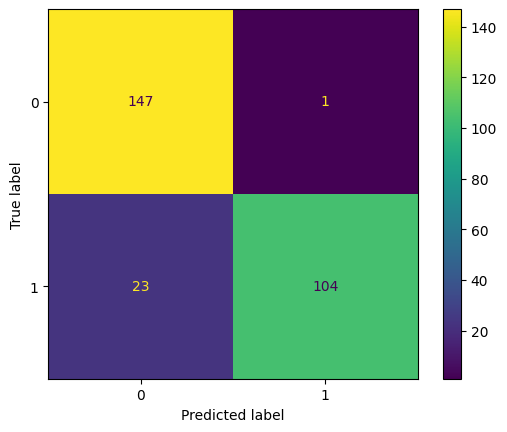

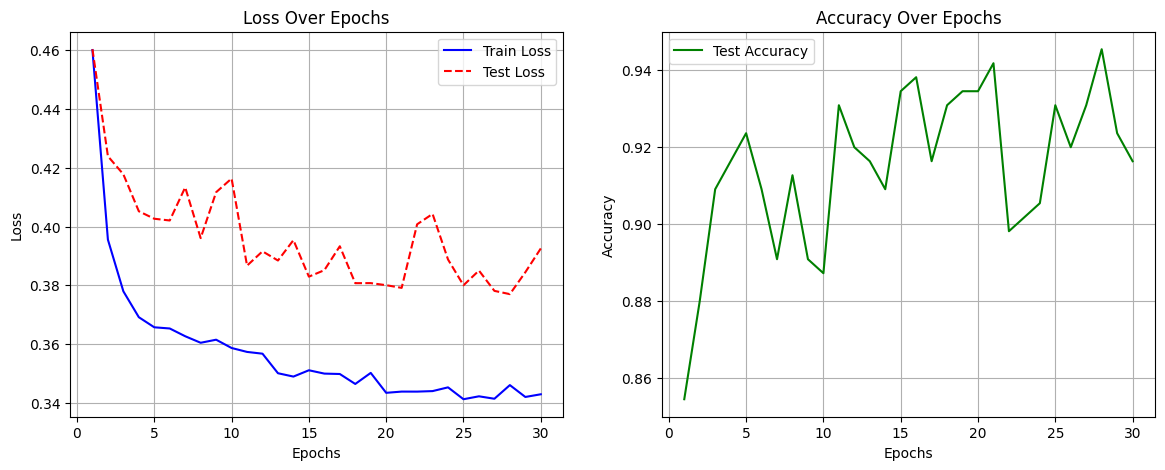

F1 SCORE:  0.896551724137931  | ACCURACY SCORE:  0.9127272727272727


In [9]:
with torch.no_grad():
    test_outputs_tensor = model(X_test_tensor)
    test_outputs = test_outputs_tensor.numpy()

predicted = np.where(test_outputs > 0, 1, -1).flatten()

c_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predicted))
c_matrix_display.plot()

epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(14, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss', color='blue')
plt.plot(epochs, test_loss_history, label='Test Loss', color='red', linestyle='--')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history, label='Test Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

print("F1 SCORE: ", f1_score(y_test, predicted), " | ACCURACY SCORE: ", accuracy_score(y_test, predicted))

In [ ]:
# --- LOAD MODEL AND TEST SINGLE EXAMPLE ---
# This cell allows you to check a single prediction without retraining.

# 1. Re-initialize the Model Architecture
N_QUBITS = 5
DEPTH = 6

# Create the ansatz and the hybrid model instance
loaded_ansatz = ansatz(N_QUBITS, DEPTH)
loaded_model = HybridModel(loaded_ansatz, N_QUBITS)
MODEL_PATH = "classic_ansatz_weights.pth"

try:
    loaded_model.load_state_dict(torch.load(MODEL_PATH))
    loaded_model.eval()
    print("Success: Model weights loaded! Ready for inference.")

except FileNotFoundError:
    print(f"Error: File '{MODEL_PATH}' not found. Please train and save the model first.")

test_idx = 15

# 3. Predict on a Test Sample
if 'X_test_tensor' in locals() and 'y_test_tensor' in locals():


    input_sample = X_test_tensor[test_idx].unsqueeze(0)
    true_label = y_test_tensor[test_idx].item()

    with torch.no_grad():
        model_output = loaded_model(input_sample).item()


    predicted_class = 1 if model_output > 0 else -1

    # Print the results
    print("\n" + "="*30)
    print(f"Test Sample Index: {test_idx}")
    print(f"Raw Model Output:  {model_output:.4f}")
    print(f"Predicted Class:   {predicted_class}")
    print(f"True Label:        {int(true_label)}")
    print("="*30)

else:
    print("Error: Data tensors not found. Please run the 'prepare_data' cells first.")

Success: Model weights loaded! Ready for inference.

Test Sample Index: 7
Raw Model Output:  -0.8268
Predicted Class:   -1
True Label:        -1
